In [45]:
# All Imports

import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob
from skimage import filters
from skimage.filters import unsharp_mask


In [ ]:
#host_prj_allangle_backup   = load_prj_std(0) # Load prelog  data
#host_scat_allangle_backup  = load_prj_std(1) # Load scatter data
#host_blank_allangle_backup = load_prj_std(2) # Load blank   data

In [2]:
# Settings Array
# CE01
# BINSx   = 3584
# BINSy   = 2816
# BINSy   = 1000

# Vsize_x = 0.085
# Vsize_y = 0.085
# Vsize_z = 1

# x_p0    = -93.5
# y_p0    = -115.0
# z_p0    = -30.0

# x_d0    = -152.32
# y_d0    = -119

In [3]:
# Ray Tracing Code


@njit(parallel=True)
def x_y_flip(host_prjbuf_temp):
    host_prjbuf_temp_gpu  = np.copy(host_prjbuf_temp)
    host_prjbuf_1view_gpu = np.copy(host_prjbuf_temp)
    
    for i in prange(BINSx):
        for j in prange(BINSy):
            bin_ind_temp = j*BINSx+i
            bin_ind      = i*BINSy+j
            host_prjbuf_1view_gpu[bin_ind] = host_prjbuf_temp_gpu[bin_ind_temp]
    
    return host_prjbuf_1view_gpu

@njit(parallel=True)
def compute_yry(host_prj_allangle, host_scat_allangle):
    all_b_size        =  ANGLES*BINSx*BINSy
    host_yry_allangle =  np.zeros(BINSx*BINSy*ANGLES)
    
    for i in prange(all_b_size):
        if (host_prj_allangle[i] == 0):
            host_yry_allangle[i] = 0
        else:
            dif = host_prj_allangle[i] - host_scat_allangle[i]
            if (dif <= 0):
                dif = host_prj_allangle[i]
            host_yry_allangle[i] = (dif*dif)/host_prj_allangle[i]
    
    return host_yry_allangle

@njit(parallel=True)
def compute_gamma_yry(host_yry_allangle, host_gamma_allangle):
    all_b_size              = ANGLES*BINSx*BINSy
    host_gamma_yry_allangle = np.zeros(all_b_size)
    
    for i in prange(all_b_size):
        host_gamma_yry_allangle[i] = host_yry_allangle[i]*host_gamma_allangle[i]
    
    return host_gamma_yry_allangle

@njit(parallel=True)
def compute_h(host_prj_sub, host_blank_sub, host_line_sub, host_scat_sub):
    ANGLES_per_sub  = int(ANGLES/subset_num)
    sub_b_size      = int(ANGLES_per_sub*BINSx*BINSy)
    
    host_sub = np.zeros(sub_b_size)
    
    for i in prange(sub_b_size):
        y_tmp       = host_blank_sub[i]*np.exp(-host_line_sub[i])
        host_sub[i] = (host_prj_sub[i]/(y_tmp+host_scat_sub[i])-1)*y_tmp
    
    return host_sub

@njit(parallel=True)
def update_est(host_est, host_capL, host_RD, host_d, host_RDD):
    f_size    = IMGSIZx*IMGSIZy*IMGSIZz
    host_est1 = np.zeros(f_size)
    
    for i in prange(f_size):
        host_est1[i] = host_est[i]-(host_capL[i]+beta*host_RD[i])/(host_d[i]+2*beta*host_RDD[i])
        if (host_est1[i] < 0):
            host_est1[i] = 0
    
    return host_est1

@njit(parallel=True)
def regroup_prj(host_uponregroup_allangle):
    all_b_size     = int(ANGLES*BINSx*BINSy)
    ANGLES_per_sub = int(ANGLES/subset_num)
    b_size         = int(BINSx*BINSy)
    
    host_allangle_tmp = np.zeros(host_uponregroup_allangle.shape)
    flag              = 0
    
    for i in range(subset_num):
        for j in range(ANGLES_per_sub):
            for k in range(b_size):
                host_allangle_tmp[flag] = host_uponregroup_allangle[int((j*subset_num+i)*b_size+k)]
                flag = flag +1
    
    return host_allangle_tmp

import math

@cuda.jit(device=True)
def rayTrace3D_GPU_direct_notexturememory_normprj(d_normprj, x0, y0, z0, x1, y1, z1, status, sum_norm, bin_ind):
    # Perform Ray Tracing
    sum_norm = 0
    dx     = x1-x0
    dy     = y1-y0
    dz     = z1-z0
    Length = math.sqrt( dx*dx+dy*dy+dz*dz )


    if (x1 != x0):
        min_lx = (x_p0-x0)/dx
        max_lx = min_lx+IMGSIZx*Vsize_x/dx

        if (min_lx > max_lx):
            #SWAP(min_lx, max_lx);
            s_temp = min_lx
            min_lx = max_lx
            max_lx = s_temp
    else:
        # the line perpendicular to x axis
        if (x0 >= IMGSIZx*Vsize_x+x_p0 or x0<=x_p0):
            status = -1
            return
        min_lx = -1e3
        max_lx = 1e3
    
    
    if (y0 != y1):
        min_ly = (y_p0-y0)/dy
        max_ly = min_ly+IMGSIZy*Vsize_y/dy

        if (min_ly > max_ly):
            #SWAP(min_ly, max_ly);
            s_temp = min_ly
            min_ly = max_ly
            max_ly = s_temp
    else:
        # the line perpendicular to y axis
        if (y0 >= IMGSIZy*Vsize_y+y_p0 or y0 <= y_p0):
            status = -1
            return
        min_ly = -1e3
        max_ly = 1e3

    
    if (z0 != z1):
        min_lz = (z_p0-z0)/dz
        max_lz = min_lz+IMGSIZz*Vsize_z/dz
        if (min_lz > max_lz):
            #SWAP(min_lz, max_lz);
            s_temp = min_lz
            min_lz = max_lz
            max_lz = s_temp
    else:
        # the line perpendicular to z axis
        if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
            status = -1
            return
        min_lz = -1e3
        max_lz = 1e3
    
    
    max_l = max_lx
    if (max_l > max_ly):
        max_l=max_ly
    if (max_l > max_lz):
        max_l = max_lz

    min_l = min_lx
    if (min_l < min_ly):
        min_l = min_ly
    if (min_l < min_lz):
        min_l = min_lz

    if (min_l >= max_l):
        status = -1
        return
    
    if (min_lx != min_l):
        prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))

        if (x0 < x1):
            min_lx= ((prev_x+1)*Vsize_x+x_p0-x0)/ dx
        else:
            if (x0 == x1):
                min_lx = 1e3
            else:
                min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
    else:
        if (x0 < x1):
            prev_x = 0
            min_lx = ( Vsize_x+x_p0-x0 )/ dx
        else:
            prev_x = IMGSIZx-1
            min_lx = ( prev_x*Vsize_x+x_p0-x0 )/ dx
    
    if (min_ly != min_l):
        prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/Vsize_y ))
        if (y0 < y1):
            min_ly = ( (prev_y+1)*Vsize_y+y_p0-y0)/ dy
        else:
            if (y0==y1):
                min_ly = 1e3
            else:
                min_ly = (prev_y*Vsize_y+y_p0-y0)/ dy
    else:
        if (y0<y1):
            prev_y = 0
            min_ly = ( Vsize_y+y_p0-y0 )/ dy
        else:
            prev_y = IMGSIZy-1
            min_ly = ( prev_y*Vsize_y+y_p0-y0 )/ dy
    
    if (min_lz != min_l):
        prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/Vsize_z ))
        if (z0 < z1):
            min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
        else:
            if (z0 == z1):
                min_lz = 1e3
            else:
                min_lz = (prev_z*Vsize_z+z_p0-z0)/ dz
    else:
        if (z0 < z1):
            prev_z = 0
            min_lz = ( Vsize_z+z_p0-z0 )/ dz
        else:
            prev_z = (int)(IMGSIZz-1)
            min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
    
    
    min_l_new = min_lx
    if (min_l_new > min_ly):
        min_l_new = min_ly
    if (min_l_new > min_lz):
        min_l_new = min_lz
    
    incx = Vsize_x/dx
    incy = Vsize_y/dy
    incz = Vsize_z/dz

    ind = 0
    
    while ( (max_l-min_l_new)/max_l > 0.000001):
        tmp_length = (min_l_new-min_l)*Length; #<-a_ij
        if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
            sum_norm = sum_norm + 1*tmp_length
        
        ind = ind + 1
        if (min_l_new == min_lx):
            if (x0 < x1):
                prev_x = prev_x + 1
                min_lx = min_lx + incx; #Vsize_x/dx
            else:
                prev_x = prev_x - 1
                min_lx = min_lx - incx; #Vsize_x/dx;
        else:
            prev_x = prev_x


        if (min_l_new == min_ly):
            if (y0 < y1):
                prev_y = prev_y + 1
                min_ly = min_ly + incy; #Vsize_y / dy;
            else:
                prev_y = prev_y - 1
                min_ly = min_ly- incy; #Vsize_y/dy;
        else:
            prev_y = prev_y


        if (min_l_new == min_lz):
            if (z0 < z1):
                prev_z = prev_z + 1
                min_lz = min_lz + incz #Vsize_z/dz;
            else:
                prev_z = prev_z - 1
                min_lz = min_lz - incz; #Vsize_z/dz
        else:
            prev_z = prev_z

        min_l     = min_l_new
        min_l_new = min_lx

        if (min_l_new > min_ly):
            min_l_new = min_ly

        if (min_l_new>min_lz):
            min_l_new=min_lz
        
        
        tmp_length = (max_l-min_l)*Length
        if ((prev_x>=0) and (prev_x<IMGSIZx) and (prev_y>=0) and (prev_y<IMGSIZy) and (prev_z>=0) and (prev_z<IMGSIZz)):
            sum_norm = sum_norm + 1*tmp_length
        
        d_normprj[bin_ind] = sum_norm

@cuda.jit(device=True)
def rayTrace3D_GPU_direct_notexturememory(d_normprj, d_prjbuf, d_objbuf, x0, y0, z0, x1, y1, z1, status):
    ix, iy   = cuda.grid(2)
    
    status   = 0
    #sum_norm = 0
    
    for a in range(angleStart, angleEnd):
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY
        
        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        fsum_norm = 0.0
        fsum      = 0.0
        
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        
        d_normprj[bin_ind] = 0
        d_prjbuf[bin_ind]  = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz
            
            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz
            
            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    fsum_norm      = fsum_norm + 1*tmp_length
                    fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
                
                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                fsum_norm      = fsum_norm + 1*tmp_length
                fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
            status2 = 100
        
        if status2 == 100:
            d_normprj[bin_ind] = fsum_norm
            d_prjbuf[bin_ind]  = fsum
        
        cuda.syncthreads()
    
@cuda.jit
def ray_trace_gpu_manyangles_direct_notexturememory_normprj(d_normprj, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    
    status   = 0
    #sum_norm = 0
    
    for a in range(angleStart, angleEnd):
        #print(a)
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY

        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        sum_norm = 0.0
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        d_normprj[bin_ind] = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz


            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz

            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    sum_norm = sum_norm + 1*tmp_length

                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                sum_norm = sum_norm + 1*tmp_length
            status2 = 100
        if status2 == 100:
            d_normprj[bin_ind] = sum_norm
        #else:
        #    d_normprj[bin_ind] = sum_norm
#         elif status == 10:
#             d_normprj[bin_ind] = 100000
#         elif status == -1:
#             d_normprj[bin_ind] = 50000
#         else:
#             d_normprj[bin_ind] = 200000
#         d_normprj[bin_ind] = Length
        cuda.syncthreads()

@cuda.jit
def ray_trace_gpu_manyangles_direct_notexturememory_OSTR_cos(d_objbuf, d_prjbuf, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    
    status   = 0
    
    for a in range(angleStart, angleEnd):
        #print(a)
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY
        
        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        sum_norm = 0.0
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        #d_prjbuf[bin_ind] = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz


            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz

            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    sum_norm = sum_norm + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length

                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                sum_norm = sum_norm + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
            status2 = 100
        
        if status2 == 100:
            d_prjbuf[bin_ind] = sum_norm*cos_theta
        cuda.syncthreads()

@cuda.jit
def ray_trace_gpu_manyangles_direct_notexturememory_cos(d_objbuf, d_prjbuf, d_normprj, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    status   = 0
    
    for a in range(angleStart, angleEnd):
        #print(a)
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY
        
        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        fsum_norm = 0.0
        fsum      = 0.0
        
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        #d_prjbuf[bin_ind] = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz


            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz

            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    fsum_norm      = fsum_norm + 1*tmp_length
                    fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length

                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                fsum_norm      = fsum_norm + 1*tmp_length
                fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
            
            status2 = 100
        if status2 == 100:
            d_normprj[bin_ind] = fsum_norm
            d_prjbuf[bin_ind]  = fsum*cos_theta
        
        cuda.syncthreads()
    
def fprojectCB_1R_GPU_OSTR_normprj(d_normprj, d_angles, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            ray_trace_gpu_manyangles_direct_notexturememory_normprj[PRJ_GRID, PRJ_THREAD](d_normprj, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY)
            #cuda.synchronize()
    return

def fprojectCB_1R_GPU_OSTR_cos(estbuf, prj_est, d_angles, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            ray_trace_gpu_manyangles_direct_notexturememory_OSTR_cos[PRJ_GRID, PRJ_THREAD](estbuf, prj_est, d_angles, d_index, 
                                                                                           angleStart, angleEnd, nbBinsX, nbBinsY)
            cuda.synchronize()
    return

def fprojectCB_1R_GPU_SART_cos(estbuf, prj_est, d_normprj, d_angles, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            ray_trace_gpu_manyangles_direct_notexturememory_cos[PRJ_GRID, PRJ_THREAD](estbuf, prj_est, d_normprj, d_angles, 
                                                                                      d_index, angleStart, angleEnd, 
                                                                                      nbBinsX, nbBinsY)
            cuda.synchronize()
    return

@cuda.jit
def SART_prj_diff_kernel(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    
    # calculate bin index
    for a in range(angleStart, angleEnd):
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy
        
        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        if normprj[bin_ind] != 0:
            diff_line[bin_ind] = prjbuf[bin_ind]#bin_ind#(prjbuf[bin_ind] - prj_est[bin_ind])/normprj[bin_ind]
        else:
            diff_line[bin_ind] = bin_ind#1
    return

@njit(parallel=True)
def SART_prj_diff(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd):
    result_diff_line = np.zeros(prjbuf.shape)
    
    #for nbBinsX in prange(nBatchBINSx):
    #    for nbBinsY in prange(nBatchBINSy):
    for bin_ind in prange(prjbuf.shape[0]):
        if normprj[bin_ind] != 0:
            result_diff_line[bin_ind] = (prjbuf[bin_ind] - prj_est[bin_ind])/normprj[bin_ind]
        else:
            result_diff_line[bin_ind] = 0.0#prjbuf[bin_ind]#bin_ind
    
    return result_diff_line

#@njit(parallel=True)
def SART_prj_diff_old(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            SART_prj_diff_kernel[PRJ_GRID, PRJ_THREAD](diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd, nbBinsX, nbBinsY)
            cuda.synchronize()
    return
#SART_prj_diff_kernel<<<PRJ_GRID,PRJ_THREAD>>>(diff_line,prjbuf,prj_est,normprj,d_index,angleStart,angleEnd,nbBinsX,nbBinsY);
#CUT_CHECK_ERROR("Kernel execution failed");
#cudaThreadSynchronize()

#def SART_prj_diff(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd):

#@cuda.jit
def bprojectCB_4B_GPU_R_SART(d_objbuf, d_prjbuf, d_prior, d_index, 
                                   d_angles, angleStart, angleEnd, lambda_parameter, beta):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    for nbatchIDx in range(nBatchXdim):
        backprj_OSSART_gpu_manyviews_R[BACKPRJ_GRID, BACKPRJ_THREAD](d_objbuf, d_prjbuf, d_prior, d_index, 
                                                                            d_angles, angleStart, angleEnd , nbatchIDx, lambda_parameter, beta)
        cuda.synchronize()
    return

@cuda.jit
def backprj_OSSART_gpu_manyviews_R(d_objbuf, d_prjbuf, d_prior, d_index, d_angles, 
                                          angleStart, angleEnd, nbatchIDx, lambda_parameter, beta):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    tid = tx
    
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel = (ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x
    
    total_sum         = 0.0
    total_sensitivity = 0.0
    
    for a in range(angleStart, angleEnd):
        u_term    = 0.0
        
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        
        #(x0,y0,z0) - source position
        x0 = sourceR*sin_theta
        z0 = sourceR*cos_theta
        y0 = sourceY
        
        #(x1,y1,z1) - center of voxel
        x1 = (ind_x+0.5)*Vsize_x + x_p0
        y1 = (ind_y+0.5)*Vsize_y + y_p0
        z1 = (ind_z+0.5)*Vsize_z + z_p0
        
        #Check FDK paper for this weight factor. This weight can be set to 1, in a simple case
        depth_weight = (x0*x0+y0*y0+z0*z0)/((x0-x1)*(x0-x1) + (y0-y1)*(y0-y1)+(z0-z1)*(z0-z1))
        
        #Do NOT Rotate (x0,y0,z0)  -theta  around the y-axis
        y0r =y0
        x0r =x0
        z0r =z0
        
        #Do NOT Rotate (x1,y1,z1)  -theta around the y-axis
        y1r = y1
        z1r = z1
        x1r = x1
        
        if (z1r != z0r):
            t = (-detectorR - z0r) / (z1r - z0r)
            x2 = x0r + (x1r - x0r) * t
            y2 = y0r + (y1r - y0r) * t
            
            weight = 1.0
            
            # BACKPROJECTION USING INTERPOLATION
            # Calculate the continuous position (in bin_index coordinate) of the projection of voxel in the detector plane.
            imb = ((float)(x2 - x_d0)/Bsize_x)
            jmb = ((float)(y2 - y_d0)/Bsize_y)
            
            ilb = (float)(math.floor(imb))
            if (imb < (ilb+0.5)):
                ilb = ilb - 1
            
            jlb = (float)(math.floor(jmb))
            if ( jmb < (jlb+0.5)):
                jlb = jlb - 1
            
            fracI = imb - (ilb+0.5)
            fracJ = jmb - (jlb+0.5)
            
            d1 = 0
            d2 = 0
            d1_sen = 0
            d2_sen = 0
        
            # Interpolation
            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = ilb*BINSy + jlb
                d1      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d1_sen  = (1-fracI) 

            if ((ilb < BINSx-1) and (ilb >= -1) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = (ilb + 1)* BINSy+ jlb
                d1      = d1 + fracI * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d1_sen  = d1_sen + fracI 

            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy-1) and (jlb >= -1)):
                bin_ind = ilb* BINSy + jlb + 1
                d2      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d2_sen   =  1-fracI 

            if ((ilb<BINSx-1) and (ilb>=-1) and (jlb<BINSy-1) and (jlb>=-1)):
                bin_ind = (ilb + 1) * BINSy +  jlb + 1
                d2 = d2 + fracI  * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d2_sen = d2_sen + fracI
            
            u_term    = (1 - fracJ) * d1 + fracJ * d2
            u_term    = u_term*Vsize_z*depth_weight
            
            u_sensitivity = ((1-fracJ)*d1_sen+fracJ*d2_sen)
            u_sensitivity = u_sensitivity *Vsize_z*depth_weight
            
            total_sum         = total_sum + (u_term*weight)
            total_sensitivity = total_sensitivity+(u_sensitivity*weight)
    
    u_term    = 0
    beta_term = 0
    
    if(total_sensitivity != 0):
        u_term    = (total_sum/total_sensitivity)
        beta_term = (beta*d_prior[ind_voxel])/total_sensitivity
    
    d_objbuf[ind_voxel] = d_objbuf[ind_voxel]+lambda_parameter*(u_term+beta_term)
    if(d_objbuf[ind_voxel] < 0):
        d_objbuf[ind_voxel] = 0
    #if(d_objbuf[ind_voxel] > 0.1):
    #    d_objbuf[ind_voxel] = 0
    
    return

@cuda.jit
def backprj_gpu_manyviews_SBP(d_objbuf, d_prjbuf, d_index, d_angles, angleStart, angleEnd , nbatchIDx):
    # Block id in a 1D grid
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    tid = tx
    
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel = (ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x
    
    total_sum = 0.0
    
    for a in range(angleStart, angleEnd):
        u_term    = 0.0
        
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        
        #(x0,y0,z0) - source position
        x0 = sourceR*sin_theta
        z0 = sourceR*cos_theta
        y0 = sourceY
        
        #(x1,y1,z1) - center of voxel
        x1 = (ind_x+0.5)*Vsize_x + x_p0
        y1 = (ind_y+0.5)*Vsize_y + y_p0
        z1 = (ind_z+0.5)*Vsize_z + z_p0
        
        #Check FDK paper for this weight factor. This weight can be set to 1, in a simple case
        depth_weight = (x0*x0 + y0*y0 + z0*z0)/((x0-x1)*(x0-x1) + (y0-y1)*(y0-y1)+(z0-z1)*(z0-z1))
        
        y0r = y0
        x0r = x0
        z0r = z0
        
        y1r = y1
        z1r = z1
        x1r = x1
        
        if (z1r != z0r):
            t = (-detectorR - z0r) / (z1r - z0r)
            x2 = x0r + (x1r - x0r) * t
            y2 = y0r + (y1r - y0r) * t
            
            weight = 1.0
            
            # BACKPROJECTION USING INTERPOLATION
            # Calculate the continuous position (in bin_index coordinate) of the projection of voxel in the detector plane.
            imb = ((float)(x2 - x_d0)/Bsize_x)
            jmb = ((float)(y2 - y_d0)/Bsize_y)
            
            ilb = (float)(math.floor(imb))
            if (imb < (ilb+0.5)):
                ilb = ilb - 1
            
            jlb = (float)(math.floor(jmb))
            if ( jmb < (jlb+0.5)):
                jlb = jlb - 1

            fracI = imb - (ilb+0.5)
            fracJ = jmb - (jlb+0.5)
            
            d1 = 0
            d2 = 0
            
            # Interpolation
            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = ilb*BINSy + jlb
                d1      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            if ((ilb < BINSx-1) and (ilb >= -1) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = (ilb + 1)* BINSy+ jlb
                d1      = d1 + fracI * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy-1) and (jlb >= -1)):
                bin_ind = ilb* BINSy + jlb + 1
                d2      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            if ((ilb<BINSx-1) and (ilb>=-1) and (jlb<BINSy-1) and (jlb>=-1)):
                bin_ind = (ilb + 1) * BINSy +  jlb + 1
                d2 = d2 + fracI  * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            u_term    = (1 - fracJ) * d1 + fracJ * d2
            u_term    = u_term*Vsize_z*depth_weight
            total_sum = total_sum + (u_term*weight)
        
    d_objbuf[ind_voxel] = d_objbuf[ind_voxel]+total_sum        
    return


def bprojectCB_GPU_SBP(d_objbuf, d_prjbuf, d_index, d_angles, angleStart, angleEnd):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    for nbatchIDx in range(nBatchXdim):
        backprj_gpu_manyviews_SBP[BACKPRJ_GRID, BACKPRJ_THREAD](d_objbuf, d_prjbuf, d_index, d_angles, angleStart, angleEnd , nbatchIDx)
        cuda.synchronize()
    return

@njit(parallel=True)
def temp_fun1(angleStart, b_size, sub_b_size, host_prj_allangle):
    host_prj_sub = np.zeros(sub_b_size)
    for i in prange(sub_b_size):
        host_prj_sub[i]   = host_prj_allangle[angleStart*b_size+i]
    return host_prj_sub

@njit(parallel=True)
def temp_fun2(subset_num, f_size, host_capL):
    temp = np.zeros(f_size)
    for i in prange(f_size):
        temp[i] = subset_num*host_capL[i]
    return temp

@cuda.jit
def G_Fessler_prior(RDD, RD, estbuf, delta, z_xy_ratio, nbatchIDx):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Thread index
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    cent = 1
    tid  = tx
    
    # Calculate the index of the voxel being considered
    # ind_x = nbatchIDx*((int)(IMGSIZx/h_nBatchXdim))+ tid
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel=int((ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x)  #(if prj is scanner data, need x_y_flip)
    #ind_voxel=(ind_z*IMGSIZx+ind_x)*IMGSIZy+ind_y;
    
    for ind_nr_z  in range(ind_z-1, ind_z+2):
        for ind_nr_y in range(ind_y-1, ind_y+2):
            for ind_nr_x in range(ind_x-1, ind_x+2):
                distance = math.sqrt(float((ind_nr_x-ind_x)*(ind_nr_x-ind_x)+(ind_nr_y-ind_y)*(ind_nr_y-ind_y)+(ind_nr_z-ind_z)*(ind_nr_z-ind_z)*z_xy_ratio*z_xy_ratio))
                
                if (distance == 0.0):
                    distance = 1.0
                    cent     = 0
                
                if ( ind_nr_x<0  or ind_nr_y<0 or ind_nr_z<0 or ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1) ):
                    ind_nr = int(ind_voxel)
                else:
                    ind_nr = int(ind_nr_x + ind_nr_y*IMGSIZx + ind_nr_z*IMGSIZx*IMGSIZy)
                
                diff        = estbuf[ind_voxel]-estbuf[ind_nr]
                denominator = 1.0+abs(diff/delta)
                RDD_tmp     = cent*(1.0/distance)/denominator
                
                RDD[ind_voxel] = RDD[ind_voxel] + RDD_tmp
                RD[ind_voxel]  = RD[ind_voxel]  + RDD_tmp*diff
                
                cent = 1 # reset cent
    return

@cuda.jit
def G_Huber_prior_sart(priorbuf, estbuf, delta, nbatchIDx):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Thread index
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    cent = 1
    tid  = tx
    
    # Calculate the index of the voxel being considered
    # ind_x = nbatchIDx*((int)(IMGSIZx/h_nBatchXdim))+ tid
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel = int((ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x)  #(if prj is scanner data, need x_y_flip)
    #ind_voxel=(ind_z*IMGSIZx+ind_x)*IMGSIZy+ind_y;
    
    for ind_nr_z  in range(ind_z-1, ind_z+2):
        for ind_nr_y in range(ind_y-1, ind_y+2):
            for ind_nr_x in range(ind_x-1, ind_x+2):
                distance = math.sqrt(float((ind_nr_x-ind_x)*(ind_nr_x-ind_x)+(ind_nr_y-ind_y)*(ind_nr_y-ind_y)+(ind_nr_z-ind_z)*(ind_nr_z-ind_z)))
                
                if (distance == 0.0):
                    distance = 1.0
                
                if ( ind_nr_x<0  or ind_nr_y<0 or ind_nr_z<0 or ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1) ):
                    ind_nr = int(ind_voxel)
                else:
                    ind_nr = int(ind_nr_x + ind_nr_y*IMGSIZx + ind_nr_z*IMGSIZx*IMGSIZy)
                
                diff        = estbuf[ind_voxel]-estbuf[ind_nr]
                denominator = math.sqrt(1.0+(diff/delta)*(diff/delta))
                
                priorbuf[ind_voxel] = priorbuf[ind_voxel] + (1.0/distance)*diff/denominator
    return    

def prior_GPU_SART(d_prior, d_est, delta):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    if (delta == 0):
        print("delta cannot be ZERO !!")
        exit(1)
    
    for nbatchIDx in range(0, nBatchXdim):
        G_Huber_prior_sart[BACKPRJ_GRID, BACKPRJ_THREAD](d_prior, d_est, delta, nbatchIDx)
        # Check out the content of this kernel in file ConebeamCT_kernel.cu
        cuda.synchronize()
    return

def prior_GPU_OSTR(d_RDD, d_RD, d_est, delta, z_xy_ratio):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    if (delta == 0):
        print("delta cannot be ZERO !!")
        exit(1)
    
    for nbatchIDx in range(0, nBatchXdim):
        G_Fessler_prior[BACKPRJ_GRID, BACKPRJ_THREAD](d_RDD, d_RD, d_est, delta, z_xy_ratio, nbatchIDx)
        # Check out the content of this kernel in file ConebeamCT_kernel.cu
        cuda.synchronize()
    return



In [80]:
# File Reading Code

def load_prj_ima():
    b_size = BINSx*BINSy
    flag2  = 0
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    
    print(BINSx*BINSy, ANGLES, prj_allangle.shape)
    x = []
    y = []

    proj_paths = glob.glob("/media/dril/ubuntudata/DBT_recon_data/"+projection_name+"/CE*.IMA")
    for p in proj_paths:
        if '.0000.' in p:
            continue
        a    = pydicom.dcmread(p)
        temp = a.pixel_array.T
        temp = np.log(10000)-np.log(temp)
        
        # Sharpening filter
        temp = unsharp_mask(temp, radius=3, amount=1, preserve_range=True)
        
        val = filters.threshold_otsu(temp)
        temp[temp < val] = 0
        
        temp = np.fliplr(temp)
        temp = temp[-BINSy:]
        
        temp = temp.flatten()
        temp = x_y_flip(temp)
        
        x.append(temp)
        y.append(float(a[0x00181530].value))
    y = np.array(y)*np.pi/180
    
    print("length x ", len(x), " ", len(y))
    y, x = zip(*sorted(zip(y, x)))
    for j in range(len(x)):
        print("Proj ", j)
        flag2 = j
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = x[j][i]
    
    return prj_allangle, y

def import_param():
    for i in range(ANGLES):
        index[i] = i
    return index

def load_prj():
    b_size = BINSx*BINSy
    flag2  = 0
    
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    scat_allangle = np.zeros(BINSx*BINSy*ANGLES)
    
    for viewangle in range(ANGLES):
        s        = viewangle + 1
        filename = basepath + filepath+str(s).zfill(4)#+'.raw'
        
        with open(filename, 'rb') as f:
            primary_plus_scatter  = np.fromfile(f, dtype=np.float32)
            host_prj_temp1        = primary_plus_scatter[:b_size]
            host_prj_temp2        = primary_plus_scatter[b_size:]
        
        host_prj_1view_temp = x_y_flip(host_prj_temp1)
        host_sct_1view_temp = x_y_flip(host_prj_temp2)
        
        print(host_prj_1view_temp.shape)
        
        # all angle together
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = host_prj_1view_temp[i]
            scat_allangle[flag2*BINSx*BINSy + i] = host_sct_1view_temp[i]
        
        flag2 = flag2+1
    return prj_allangle, scat_allangle
    
def load_prj_std(data_type):
    b_size = BINSx*BINSy
    flag2  = 0
    
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    #scat_allangle = np.zeros(BINSx*BINSy*ANGLES)
    
    for viewangle in range(ANGLES):
        s        = viewangle + 1
        
        if data_type   == 0:
            #filename = basepath + 'OSTR_prelog/'+projection_name+str(s).zfill(4)#+".raw"
            filename = basepath + 'Projections_Renamed_Seg/'+projection_name+str(s).zfill(4)#+".raw"
        elif data_type == 1:
            filename = basepath + 'OSTR_scatter/'+scatter_name+str(s).zfill(4)#+".raw"
        else:
            filename = basepath + 'OSTR_blank/'+blank_name+str(s).zfill(4)#+".raw"
        
        #print(filename)
        with open(filename, 'rb') as f:
            #data  = np.load(f)
            data  = np.fromfile(f, dtype=np.float32)
            # If doign SART
            #data  = np.log(10000) - np.log(data)
            
            #print(data.shape)
            #data  = np.reshape(data, (1400, 3584))
            #data  = data[:1400, :]
            #data  = np.flip(data, 0)
            #data  = data.flatten()
            #print(data.shape)
                #data  = np.fromfile(f, dtype=np.float32)
        #np.save(filename+'.npy', data)
        proj = x_y_flip(data)
        
        # all angle together
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = proj[i]
        
        flag2 = flag2+1
    
    return prj_allangle


In [77]:
# Settings Part


projection_name = "CE27"#"CE26.3584x1000."#"OSTR_LE.3584x1400."
scatter_name    = "OSTR_scatter.3584x1400." 
blank_name      = "OSTR_blank.3584x1400."

IMGSIZx = 2600
IMGSIZy = 1200
IMGSIZz = 48
f_size  = IMGSIZx*IMGSIZy*IMGSIZz

BINSx   = 3584
#BINSy   = 2816
BINSy   = 1600

Vsize_x = 0.085
Vsize_y = 0.085
Vsize_z = 1

x_p0    = -106.25
y_p0    = -107.1
z_p0    = -30.0

x_d0    = -152.32
y_d0    = -137.7

Bsize_x = 0.085
Bsize_y = 0.085
b_size  = BINSx*BINSy

ANGLES  = 25
index   = []
angles  = []


detectorR = 47.0
sourceR   = 608.5
sourceY   = 0.0

# Tuning Parameters
beta  = 1000
delta = 0.03
#####################

iter_num   = 5
subset_num = 5

IO_Iter = 0
method  = 0


BACKPRJ_ThreX = 390
BACKPRJ_ThreY = 1
BACKPRJ_GridX = 1000
BACKPRJ_GridY = 48
nBatchXdim    = 8

nBatchBINSx = 1
nBatchBINSy = 1

PRJ_ThreX = 16
PRJ_ThreY = 16
PRJ_GridX = 224
PRJ_GridY = 100


f_size     = IMGSIZx*IMGSIZy*IMGSIZz
all_b_size = ANGLES*BINSx*BINSy
sub_b_size = BINSx*BINSy

In [81]:
# Code for doing SART Recon
#h_angles
host_prj_allangle_backup, h_angles   = load_prj_ima()
h_angles = list(h_angles)

h_index   = np.array(list(range(0, 25)))

d_angles = cuda.to_device(h_angles)
d_index  = cuda.to_device(h_index)

angleStart = 0
angleEnd   = 25


host_prj_allangle   = copy.deepcopy(host_prj_allangle_backup) #load_prj_std(0) # Load prelog  data

host_prj_allangle   = regroup_prj(host_prj_allangle)

index_tmp = np.zeros(ANGLES)
for i in range(0, ANGLES):
    index_tmp[i] = h_index[i]

flag           = 0
ANGLES_per_sub = int(ANGLES/subset_num)
h_index        = np.zeros(ANGLES, dtype=int)

for i in range(0, subset_num):
    for j in range(0, ANGLES_per_sub):
        h_index[flag] = index_tmp[j*subset_num+i]
        flag          = flag + 1
        


sub_b_size     = ANGLES_per_sub*b_size

print('sub_b_size is ', sub_b_size)
print('delta is ',      delta)
print("Indexes are ",   h_index)

5734400 25 (143360000,)
length x  25   25
Proj  0
Proj  1
Proj  2
Proj  3
Proj  4
Proj  5
Proj  6
Proj  7
Proj  8
Proj  9
Proj  10
Proj  11
Proj  12
Proj  13
Proj  14
Proj  15
Proj  16
Proj  17
Proj  18
Proj  19
Proj  20
Proj  21
Proj  22
Proj  23
Proj  24
sub_b_size is  28672000
delta is  0.001
Indexes are  [ 0  5 10 15 20  1  6 11 16 21  2  7 12 17 22  3  8 13 18 23  4  9 14 19
 24]


In [ ]:
# Recon Loop

beta_array       = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0]
delta_array      = [0.001, 0.0005, 0.0001, 0.00005, 0.00001]
lambda_parameter = 0.9

for beta in beta_array:
    for delta in delta_array:
        print("Reconstructing ", beta, delta)
        
        d_line_sub     = cuda.device_array(int(sub_b_size))
        d_normprj      = cuda.device_array(int(sub_b_size))

        d_index        = cuda.to_device(h_index)

        host_est      = np.zeros(f_size, np.float32)
        d_est         = cuda.to_device(host_est)

        host_prj_est  = np.zeros(f_size, np.float32)
        prj_est       = cuda.to_device(host_prj_est)

        host_prj_est  = np.zeros(f_size, np.float32)
        prj_est       = cuda.to_device(host_prj_est)

        d_prior       = np.zeros(f_size, np.float32)
        d_prior       = cuda.to_device(d_prior)

        d_diff_line_sub = cuda.device_array(int(sub_b_size))
        d_normprj_sub   = cuda.device_array(int(sub_b_size))
        d_prj_est_sub   = cuda.device_array(int(sub_b_size))
        #d_prj_buf_sub   = cuda.device_array(int(sub_b_size))

        for i in range(0, 5):
            #print("Iteration ", i)
            for a in range(0, 5):
                angleStart = a*ANGLES_per_sub
                angleEnd   = (a+1)*ANGLES_per_sub

                host_prj_sub  = temp_fun1(angleStart, b_size, sub_b_size, host_prj_allangle)
                d_prj_buf_sub = cuda.to_device(host_prj_sub)

                d_prior       = np.zeros(f_size, np.float32)
                d_prior       = cuda.to_device(d_prior)

                prior_GPU_SART(d_prior, d_est, delta)

                fprojectCB_1R_GPU_SART_cos(
                    d_est,
                    d_prj_est_sub,
                    d_normprj_sub,
                    d_angles,
                    d_index,
                    angleStart,
                    angleEnd)

                #d_normprj_sub
                h_diff_line_sub  = d_diff_line_sub.copy_to_host()
                h_normprj_sub    = d_normprj_sub.copy_to_host()
                h_prj_est_sub    = d_prj_est_sub.copy_to_host()

                #h_normprj_sub[h_normprj_sub  < 0.5] = 10000

                result_diff = SART_prj_diff(h_diff_line_sub,
                    host_prj_sub,
                    h_prj_est_sub,
                    h_normprj_sub,
                    h_index,
                    angleStart,
                    angleEnd)

                #result_diff[result_diff > 0.5] = 0
                #result_diff[result_diff > 100] = 0
                #result_diff = np.nan_to_num(np.divide(host_prj_sub - h_prj_est_sub, h_normprj_sub))

                d_diff_line_sub = cuda.to_device(result_diff)

                bprojectCB_4B_GPU_R_SART (d_est, d_diff_line_sub, d_prior,
                                          d_index,
                                          d_angles,
                                          angleStart,
                                          angleEnd,
                                          lambda_parameter, beta)

                d_prj_est_sub = np.zeros(d_prj_est_sub.shape)
                d_prj_est_sub = cuda.to_device(d_prj_est_sub)

                d_normprj_sub = np.zeros(d_normprj_sub.shape)
                d_normprj_sub = cuda.to_device(d_normprj_sub)

                d_prj_buf_sub = np.zeros(d_prj_buf_sub.shape)
                d_prj_buf_sub = cuda.to_device(d_prj_buf_sub)

        host_est = d_est.copy_to_host()
        host_est.astype('float32').tofile('/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/'+projection_name+'_'+str(IMGSIZx)+'x'+str(IMGSIZy)+'x'+str(IMGSIZz)+'.'+str(i)+'_'+str(delta)+'_'+str(beta)+'.raw')

Reconstructing  -0.6 0.001
Reconstructing  -0.6 0.0005
Reconstructing  -0.6 0.0001
Reconstructing  -0.6 5e-05
Reconstructing  -0.6 1e-05
Reconstructing  -0.5 0.001
Reconstructing  -0.5 0.0005
Reconstructing  -0.5 0.0001
Reconstructing  -0.5 5e-05
Reconstructing  -0.5 1e-05
Reconstructing  -0.4 0.001
Reconstructing  -0.4 0.0005
Reconstructing  -0.4 0.0001
Reconstructing  -0.4 5e-05
Reconstructing  -0.4 1e-05
Reconstructing  -0.3 0.001
Reconstructing  -0.3 0.0005
Reconstructing  -0.3 0.0001
Reconstructing  -0.3 5e-05


(array([2761986.,       0.,       0.,       0.,       0.,       0.,
          52836.,  289866., 1590221., 1039491.]),
 array([0.        , 0.48928523, 0.97857046, 1.46785569, 1.95714092,
        2.44642615, 2.93571138, 3.42499661, 3.91428185, 4.40356708,
        4.89285231]),
 <a list of 10 Patch objects>)

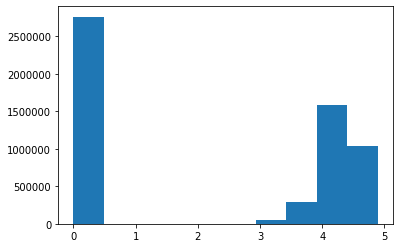

In [74]:
plt.hist(a[0, :, :].flatten())

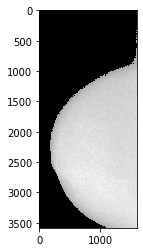

In [75]:
a = np.reshape(host_prj_allangle_backup, [25, BINSx, BINSy])
plt.imshow(a[0, :, :], cmap='gray')
#print(len(host_prj_allangle_backup))

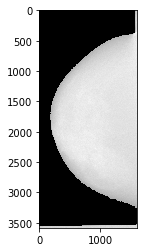

In [33]:
projection_name = "CE27"
a = np.reshape(host_prj_allangle_backup, [25, BINSx, BINSy])
plt.imshow(a[24, :, :], cmap='gray')